# download packages

In [8]:
import warnings # tf needs to learn to stfu
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [9]:
!pip install plotly

# Import the libraries

In [38]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# prepare train test splits

In [11]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

# Prepare model

In [12]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;


# prepare the training plan

In [13]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto')
                               #, restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

# **KFOLD Cross Validation**

In [39]:
def create_kfold(X_train,X_test,Y_train,Y_test,num_folds,epochs):
    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((Y_train, Y_test), axis=0)
    acc_per_fold=[]
    loss_per_fold=[]
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
    fold_no=1
    for train,test in kfold.split(inputs,targets):
        model=create_model()
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        history = train_model(model, inputs[train], targets[train],EPOCHS=epochs)
        plot_model_training_curve(history)
        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        model_file='skin_caner_5folds_'+str(fold_no)+'.h5'
        model.save(model_file)
        # Increase fold number
        fold_no = fold_no + 1
    return acc_per_fold,loss_per_fold

In [15]:
def get_avg(acc_per_fold,loss_per_fold):
    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

# test the model

In [ ]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show()
    return y_true, y_pred

# training curves plot

In [16]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()

# multi class confusion matrix

In [ ]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name, y_true,y_pred):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = y_pred,y_true

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [ ]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('C:\\Users\\Marwan Gamal\\Downloads\\Skin Cancer\\Photo\\' + name + '_confusion_matrix.png', dpi=300)

# read the data

In [17]:
base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/", '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [18]:
data = pd.read_csv(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/",'HAM10000_metadata.csv'))

# Creating New Columns for better readability

# data['path'] = data['image_id'].map(imageid_path_dict.get)
# data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
# data['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [19]:
# Now lets see the sample of tile_df to look on newly made columns
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [20]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


In [21]:
data.isnull().any().sum()

1

# Imputing the Null values and preparing the data

In [22]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [23]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [24]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...


In [25]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [26]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,Benign keratosis-like lesions (bkl),../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."


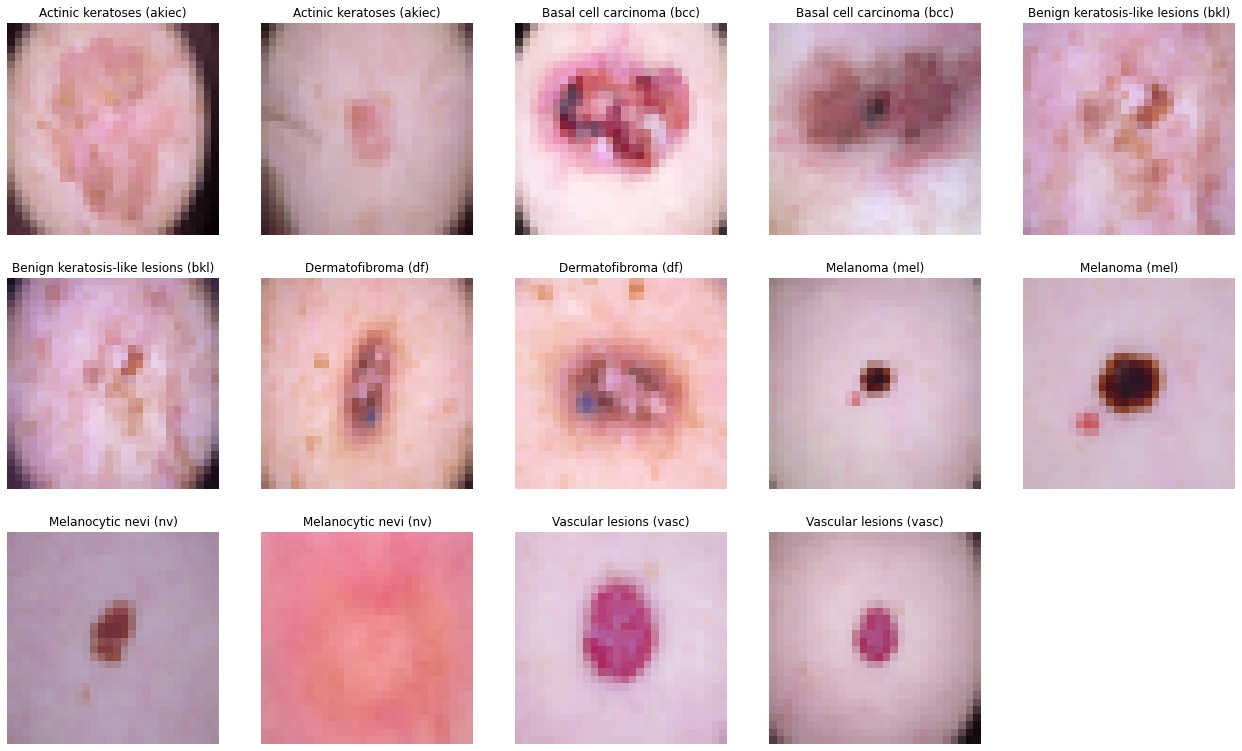

In [27]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [28]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [29]:
counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)
    

In [30]:
len(frames)

7

In [31]:
final_data = pd.concat(frames)

In [32]:
print(data.shape)
print(final_data.shape)

(10015, 12)
(45756, 12)


In [33]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [34]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


In [35]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [40]:
acc_per_fold, loss_per_fold=create_kfold(X_train_orig,X_test_orig,Y_train_orig,Y_test_orig,8,50)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 4, 4, 128)        

Score for fold 1: loss of 0.8089279532432556; accuracy of 73.64217042922974%
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 4, 4, 64)          0         
___________________________________________

Score for fold 2: loss of 0.8533401489257812; accuracy of 74.60063695907593%
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 4, 4, 64)          0         
__________________________________________

Score for fold 3: loss of 0.7621782422065735; accuracy of 74.5207667350769%
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 4, 4, 64)          0         
___________________________________________

Score for fold 4: loss of 0.7115439772605896; accuracy of 75.0%
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 4, 4, 64)          0         
_______________________________________________________

Score for fold 5: loss of 0.7410516738891602; accuracy of 74.76038336753845%
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 4, 4, 64)          0         
__________________________________________

Score for fold 6: loss of 0.8267122507095337; accuracy of 73.96166324615479%
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 4, 4, 64)          0         
__________________________________________

Score for fold 7: loss of 0.635749340057373; accuracy of 76.11821293830872%
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 4, 4, 64)          0         
___________________________________________

Score for fold 8: loss of 0.6689651608467102; accuracy of 74.42046403884888%


In [37]:
get_avg(acc_per_fold,loss_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.6743655204772949 - Accuracy: 76.67731642723083%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.673231303691864 - Accuracy: 75.55910348892212%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.7304643392562866 - Accuracy: 74.04153347015381%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.7973509430885315 - Accuracy: 74.12140369415283%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.7267134189605713 - Accuracy: 73.80191683769226%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.7372435331344604 - Accuracy: 72.68370389938354%
------------------------------------------------------------------------


In [ ]:
model =create_model()

In [41]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [42]:
acc_per_fold, loss_per_fold=create_kfold(X_train_aug,X_test_aug,Y_train_aug,Y_test_aug,5,50)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 4, 4, 128)       

Score for fold 1: loss of 0.08809958398342133; accuracy of 98.02228808403015%
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________

Score for fold 2: loss of 0.08697561174631119; accuracy of 98.05485606193542%
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________

Score for fold 3: loss of 0.09181757271289825; accuracy of 97.79258966445923%
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________

Score for fold 4: loss of 0.07933050394058228; accuracy of 98.1532096862793%
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 4, 4, 64)          0         
__________________________________________

Score for fold 5: loss of 0.09483923763036728; accuracy of 98.06578755378723%


In [43]:
get_avg(acc_per_fold,loss_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.08809958398342133 - Accuracy: 98.02228808403015%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.08697561174631119 - Accuracy: 98.05485606193542%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.09181757271289825 - Accuracy: 97.79258966445923%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.07933050394058228 - Accuracy: 98.1532096862793%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.09483923763036728 - Accuracy: 98.06578755378723%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 98.01774621009827 (+- 0.12062467728353349)
> Loss: 0.08821250200271606
----------------------

In [ ]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

In [ ]:
model

# save model

In [ ]:
model.save('Skin_Cancer.h5')

In [ ]:
from IPython.display import FileLink
FileLink('Skin_Cancer.h5')

# save model weights

In [ ]:
model.save_weights("Skin_Cancer.hdf5")

In [ ]:
from IPython.display import FileLink
FileLink('Skin_Cancer.hdf5')

In [ ]:
plot_model_training_curve(model2_history)

In [ ]:
y_true, y_pred=test_model(model, X_test_orig, Y_test_orig)

In [ ]:
data.head()
data.iloc[2]

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred  = model.predict(X_test_orig).round()

In [ ]:
'''單張圖片的預測1'''
one_picture_predict_data = data.iloc[2]
print(one_picture_predict_data)
print(one_picture_predict_data.dx)
#print(one_picture_predict_data.image_pixel)
y_value = reverse_label_mapping.get(one_picture_predict_data.dx)
print(y_value)


one_picture_predict_data.image_pixel.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

In [ ]:
'''單張圖片的預測2'''
print(data.iloc[2].path)
im = np.asarray(Image.open(data.iloc[2].path))
im.shape
im = im.reshape((1,450,600,3))
im.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

In [ ]:
y_true_aug, y_pred_aug = test_model(model, X_test_aug,Y_test_aug)

In [ ]:
 create_confusion_matrix(model, X_test_aug, Y_test_aug, label_mapping, 'confustion', y_true_aug, y_pred_aug)